In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [38]:
# Read all data files of one category.
import os

category = 'fibro'
downsample_steps = {'alive': 2, 'fibro': 5, 'plastic': 5}  # TODO: Rename var.

data_dir = 'data/JulianTrajs/' + category
trajectories = []
filenames = os.listdir(data_dir)    
for filename in filenames:
    trajectory = np.genfromtxt(os.path.join(data_dir, filename))
#     for start in range(1):
#         end = -(downsample_steps[category] - start)
#         sliced_trajectory = trajectory[start:end:downsample_steps[category]]
    trajectories.append(trajectory[::downsample_steps[category]])
trajectories = np.array(trajectories)

print "Category {}: Found {} files, created {} trajectories".format(category, len(filenames), len(trajectories))

Category fibro: Found 69 files, created 69 trajectories


In [39]:
def to_velocities(x, multiple_trajectories=False):
    return np.diff(x, axis=int(multiple_trajectories)) / 5.
# TODO: Does only work for single trajectory right now, extend to multiple trajectories if needed.
def to_positions(x):
    return np.append(np.zeros((1, 3)), np.cumsum(x * 5., axis=0), axis=0)

In [40]:
trajectories = to_velocities(trajectories, multiple_trajectories=True)

In [41]:
# Normalize trajectories to [-1, 1] for the LSTM network (it outputs values between -1 and 1 by default)
# TODO: Do not use min/max values here but fixed value to generalize to other datasets.

# TODO: Normalize by just dividigng through abs_max_value (i. e. not moving the mean).

min_value = np.min(trajectories)
max_value = np.max(trajectories)
abs_max_value = max(abs(min_value), abs(max_value))
print abs_max_value
def normalize(x):
    #return x / abs_max_value
    return np.interp(x, [min_value, max_value], [-1., 1.])
def denormalize(x):
    #return x * abs_max_value
    return np.interp(x, [-1., 1.], [min_value, max_value])
    
normalize(2)

5.268395


0.5231120425031612

In [6]:
# Normalize to mean 0 and standard deviation 0.5.
# TODO: Evaluate if this is better than normalizing to [-1, 1].
traj_means = np.mean(trajectories, axis=(0, 1))
traj_stds = np.std(trajectories, axis=(0, 1))

def normalize(x):
    return np.nan_to_num((x - traj_means) / (3. * traj_stds))
def denormalize(x):
    return x * 3. * traj_stds + traj_means

In [ ]:
denormalize(normalize(trajectories))

In [131]:
np.min(trajectories), np.max(trajectories)

(-4.7380486419543795, 3.7517556109821979)

In [42]:
trajectories = normalize(trajectories)

In [92]:
np.mean(trajectories, axis=(0, 1)), np.std(trajectories, axis=(0, 1))
# fibro, norm by dividing through abs_max_value: 0.0015, 0.0015, 0
# fibro, norm to [-1, 1]: 0.12, 0.12, 0.11
# fibro, norm to [0, 1]: 0.558, 0.558, 0.557

(array([ 0.10571516,  0.10590868,  0.10400657]),
 array([  1.26773006e-01,   1.28410260e-01,   5.73152636e-15]))

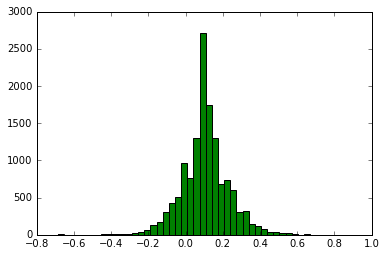

In [93]:
n, bins, patches = plt.hist(trajectories[:, :, 0].flatten(), bins=51, facecolor='green')

In [43]:
batch_size = len(trajectories)
num_timesteps = len(trajectories[0])

In [44]:
# Layer implementing a Gaussian mixture model.
# Implementation largely follows https://github.com/fchollet/keras/issues/1061.
# In contrast to the original code, the loss was divided by sqrt(2 pi) to use the same Gaussian as in numpy.random.norm 

from keras.layers import Layer
# TODO: This is only implemented for theano, rewrite it using keras.backend (as an exercise).
import theano
import theano.tensor as T

class GMMActivation(Layer):
    """
    GMM-like activation function.
    Assumes that input has (D+2)*M dimensions, where D is the dimensionality of the 
    target data. The first M*D features are treated as means, the next M features as 
    standard devs and the last M features as mixture components of the GMM. 
    """
    def __init__(self, M, **kwargs):
        super(GMMActivation, self).__init__(**kwargs)
        self.M = M

    def get_output(self, train=False):
        X = self.get_input(train)
        D = T.shape(X)[1]/self.M - 2
        # leave mu values as they are since they're unconstrained
        # scale sigmas with exp, s.t. all values are non-negative 
        X = T.set_subtensor(X[:,D*self.M:(D+1)*self.M], T.exp(X[:,D*self.M:(D+1)*self.M]))
        # scale alphas with softmax, s.t. that all values are between [0,1] and sum up to 1
        X = T.set_subtensor(X[:,(D+1)*self.M:(D+2)*self.M], T.nnet.softmax(X[:,(D+1)*self.M:(D+2)*self.M]))
        return X

    def get_config(self):
        config = {"name": self.__class__.__name__,
                  "M": self.M}
        base_config = super(GMMActivation, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

def gmm_loss(y_true, y_pred):
    """
    GMM loss function.
    Assumes that y_pred has (D+2)*M dimensions and y_true has D dimensions. The first 
    M*D features are treated as means, the next M features as standard devs and the last 
    M features as mixture components of the GMM. 
    """
    def loss(m, M, D, y_true, y_pred):
        mu = y_pred[:,D*m:(m+1)*D]
        sigma = y_pred[:,D*M+m]
        alpha = y_pred[:,(D+1)*M+m]
        return (alpha/sigma/np.sqrt(2. * np.pi)) * T.exp(-T.sum(T.sqr(mu-y_true),-1)/(2*sigma**2))

    D = T.shape(y_true)[1]
    M = T.shape(y_pred)[1]/(D+2)
    seq = T.arange(M)
    result, _ = theano.scan(fn=loss, outputs_info=None, 
    sequences=seq, non_sequences=[M, D, y_true, y_pred])
    return -T.log(result.sum(0))

In [45]:
# Set up the network.
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM
from keras.optimizers import RMSprop

model = Sequential()
model.add(LSTM(batch_input_shape=(batch_size, 1, 3), output_dim=10, return_sequences=False, stateful=True))
# model.add(LSTM(batch_input_shape=(batch_size, 1, 3), output_dim=100, return_sequences=True, stateful=True))

#model.add(LSTM(output_dim=100, return_sequences=True, stateful=True))
#model.add(LSTM(output_dim=100, return_sequences=True, stateful=True))

#model.add(LSTM(output_dim=100, return_sequences=True, stateful=True))
#model.add(LSTM(output_dim=100, return_sequences=False, stateful=True))
num_mixture_components = 10  # TODO: Play around with this parameter.
model.add(Dense( (3+2) * num_mixture_components ))
model.add(GMMActivation(num_mixture_components))
model.compile(loss=gmm_loss, optimizer=RMSprop(lr=0.001))

D:\Python\27_32bit\lib\site-packages\ipykernel\__main__.py:28: DeprecationWarning: Division of two integer types with x / y is deprecated, please use x // y for an integer division.
D:\Python\27_32bit\lib\site-packages\ipykernel\__main__.py:56: DeprecationWarning: Division of two integer types with x / y is deprecated, please use x // y for an integer division.


In [46]:
losses = []

In [47]:
# Train on complete trajectories.
num_epochs = 400
model.reset_states()
for epoch in range(1, num_epochs+1):
    print 'Epoch', epoch,
    losses_epoch = []
    for i in range(num_timesteps - 1):
        results = model.train_on_batch(trajectories[:, i:i+1], trajectories[:, i+1])
        losses_epoch.append(results[0])
    mean_loss = np.mean(losses_epoch)
    print '- loss:', mean_loss
    losses.append(mean_loss)
    model.reset_states()

Epoch 1 - loss: 0.282786712673
Epoch 2 - loss: -0.400344615879
Epoch 3 - loss: -0.523922874941
Epoch 4 - loss: -0.608253914255
Epoch 5 - loss: -0.664923030996
Epoch 6 - loss: -0.698109053875
Epoch 7 - loss: -0.719802633144
Epoch 8 - loss: -0.732929970559
Epoch 9 - loss: -0.740896476744
Epoch 10 - loss: -0.746090542935
Epoch 11 - loss: -0.749729930052
Epoch 12 - loss: -0.752425811439
Epoch 13 - loss: -0.754505831237
Epoch 14 - loss: -0.756193250384
Epoch 15 - loss: -0.757596415682
Epoch 16 - loss: -0.758792007263
Epoch 17 - loss: -0.759827734917
Epoch 18 - loss: -0.76070708442
Epoch 19 - loss: -0.761472991263
Epoch 20 - loss: -0.762185559248
Epoch 21 - loss: -0.762832514304
Epoch 22 - loss: -0.763423602586
Epoch 23 - loss: -0.763969553113
Epoch 24 - loss: -0.764471708093
Epoch 25 - loss: -0.764941511468
Epoch 26 - loss: -0.765379798123
Epoch 27 - loss: -0.765792273689
Epoch 28 - loss: -0.766181392592
Epoch 29 - loss: -0.766548988564
Epoch 30 - loss: -0.766900119555
Epoch 31 - loss: -0.7

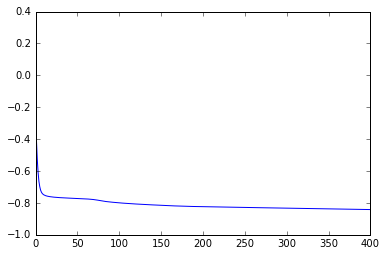

In [48]:
plt.plot(losses)

In [49]:
# Predict next timesteps using the training data as input (i. e. not the predictions themselves!).
model.reset_states()
predicted = []
predicted.append(trajectories[:, 0])  # Take first timestep from training data so predicted and expected have the same dimensions.

for i in range(num_timesteps - 1):
    pred_parameters = model.predict_on_batch(trajectories[:, i:i+1])[0]
    means = pred_parameters[:, :num_mixture_components * 3]
    sds = pred_parameters[:, num_mixture_components * 3:num_mixture_components * (3 + 1)]
    weights = pred_parameters[:, num_mixture_components * (3 + 1):]
    
    # Reshape arrays to allow broadcasting of means (3-dimensional vectors) and sds/weights (scalars).
    means = means.reshape(-1, num_mixture_components, 3)
    sds = sds[:, :, np.newaxis]
    weights = weights[:, :, np.newaxis]
    
    pred = weights * np.random.normal(means, sds)
    pred = np.sum(pred, axis=1)
    predicted.append(pred)
    
predicted = np.array(predicted)
predicted = predicted.transpose((1, 0, 2))
expected = trajectories

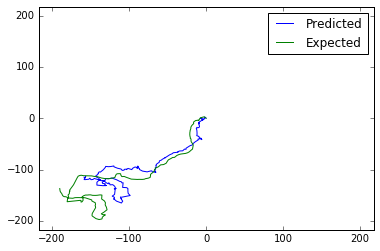

In [50]:
# Plot single trajectory from velocities.
i_traj = 3
pr = to_positions(denormalize(predicted[i_traj]))
plt.plot(pr[:, 0], pr[:, 1], label='Predicted')
exp = to_positions(denormalize(expected[i_traj]))
plt.plot(exp[:, 0], exp[:, 1], label='Expected')
lim = abs(max(np.min(pr), np.max(pr), np.min(exp), np.max(exp), key=abs)) + 20
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)
plt.legend()

# TODO: Due to training on velocities, predicted trajectories are often scaled versions of expected trajectories.

(-300, 300)

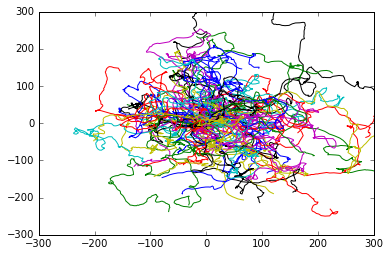

In [56]:
# Plot multiple trajectories from velocities.
for traj in predicted:
    pr = to_positions(denormalize(traj))
    plt.plot(pr[:, 0], pr[:, 1], label='Predicted')
lim = 300#abs(max(np.min(pr), np.max(pr), np.min(exp), np.max(exp), key=abs)) + 20
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)

In [52]:
# Predict new trajectories one timestep after another using a seed.

len_seed = 20  # TODO: Play around with seed size.
predicted = np.zeros((batch_size, num_timesteps, 3))

# Take starts of training trajectories as seed.
predicted[:, :len_seed] = trajectories[:, :len_seed]

# Take random values as seed.
#predicted[:, :len_seed] = 2. * (np.random.rand(batch_size, len_seed, 3) - 0.5)

# Disable both lines above to take 0 values as seed.

model.reset_states()

log_traj = 0
    
for i in range(num_timesteps - 1):
    model_input = predicted[:, i:i+1]
    pred_parameters = model.predict_on_batch(model_input)[0]
    means = pred_parameters[:, :num_mixture_components * 3]
    sds = pred_parameters[:, num_mixture_components * 3:num_mixture_components * (3 + 1)]
    weights = pred_parameters[:, num_mixture_components * (3 + 1):]
        
    # Reshape arrays to allow broadcasting of means (3-dimensional vectors) and sds/weights (scalars).
    means = means.reshape(-1, num_mixture_components, 3)
    sds = sds[:, :, np.newaxis]
    weights = weights[:, :, np.newaxis]
    
    pred = weights * np.random.normal(means, sds)
    pred = np.sum(pred, axis=1)    
    model_output = pred
    
    # Add random noise to the output values.
    #model_output += 0.25 * (np.random.rand(batch_size, 3) - 0.5)
    
    print 'Tr {}, step {}: In: {} - Out: {}'.format(log_traj, i, model_input[log_traj], model_output[log_traj]), 
    
    if i+1 >= len_seed:
        predicted[:, i+1] = model_output
        print '--> Storing at {}'.format(i+1)
    else:
        print '--> Seed'

expected = trajectories

Tr 0, step 0: In: [[ 0.06351885  0.08668991  0.10400657]] - Out: [-0.04956978 -0.0326333   0.07198016] --> Seed
Tr 0, step 1: In: [[ 0.1024049   0.11539855  0.10400657]] - Out: [ 0.09434755  0.26661179  0.13742676] --> Seed
Tr 0, step 2: In: [[ 0.10156693  0.10923705  0.10400657]] - Out: [ 0.03365272  0.04011592  0.09401321] --> Seed
Tr 0, step 3: In: [[ 0.11552394  0.09988237  0.10400657]] - Out: [ 0.13049517  0.07547675  0.0665848 ] --> Seed
Tr 0, step 4: In: [[ 0.10199371  0.15295     0.10400657]] - Out: [-0.02882956  0.07653648  0.07468919] --> Seed
Tr 0, step 5: In: [[ 0.07551684  0.13177675  0.10400657]] - Out: [ 0.03413735  0.13948424  0.11804359] --> Seed
Tr 0, step 6: In: [[ 0.06854046  0.07888557  0.10400657]] - Out: [ 0.03304753  0.03354348  0.0560774 ] --> Seed
Tr 0, step 7: In: [[ 0.09612006  0.14442355  0.10400657]] - Out: [ 0.08009096  0.07098076  0.03491483] --> Seed
Tr 0, step 8: In: [[ 0.09603779  0.12826191  0.10400657]] - Out: [ 0.14359401  0.10615161  0.09705327] -

In [21]:
np.mean(predicted, axis=(0, 1))
# fibro, norm to 0.33 std, 100 epochs: 0.10, 0.035, 0
# fibro, norm by dividing through abs_max_value, 100 epochs: 0.009, -0.015, -0.002
# fibro, norm by dividing through abs_max_value, 100 epochs: 0.017, -0.008, -0.002
# fibro, norm to [-1, 1], 100 epochs: 0.135, 0.115, 0.115 (minus default ca. 0.02, 0, 0)
# fibro, norm to [-1, 1], 200 epochs: 0.125, 0.110, 0.113 (minus default ca. 0.01, -0.006, -0.003)
# fibro, norm to [-1, 1], 500 epochs: 0.135, 0.115, 0.115 (minus default ca. 0.02, 0, 0)


array([ 0.12987534,  0.12816704,  0.10397866])

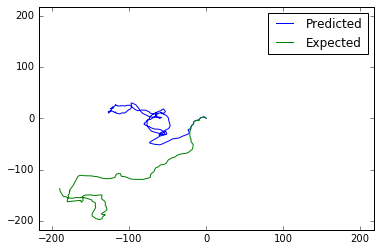

In [53]:
# Plot single trajectory from velocities.
i_traj = 3
pr = to_positions(denormalize(predicted[i_traj]))
plt.plot(pr[:, 0], pr[:, 1], label='Predicted')
exp = to_positions(denormalize(expected[i_traj]))
plt.plot(exp[:, 0], exp[:, 1], label='Expected')
lim = abs(max(np.min(pr), np.max(pr), np.min(exp), np.max(exp), key=abs)) + 20
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)
plt.legend()

(-300, 300)

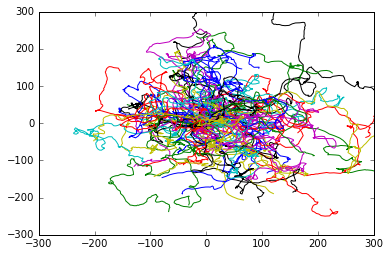

In [57]:
# Plot multiple trajectories from velocities.
for traj in predicted:
    pr = to_positions(denormalize(traj))
    plt.plot(pr[:, 0], pr[:, 1], label='Predicted')
lim = 300#abs(max(np.min(pr), np.max(pr), np.min(exp), np.max(exp), key=abs)) + 20
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)

In [25]:
# Save generated trajectories to file.
for i, trajectory in enumerate(predicted):
    np.savetxt('data/generated/{}/cell{:03d}.dat'.format(category, i+1), to_positions(denormalize(trajectory)))